## Content

1. EDA
> Utilize a subset of freeform response features to inspect from the water security and/or climate risk responses
  * CDP Cities
  * CDP Water
  * CDP Climate Change

2. Baseline
> Apply your choice of NLP application (Sentiment Analysis, Classification, Question Answering, etc.) to the subset of data you chose. Consider what metrics you will use to benchmark the success of your solutions

  Configure metric/metrics for water risk using [Aqueduct GlobalMaps 3.0 Baseline Annual Water Risk](https://www.kaggle.com/datasets/rebeccaverghese/aqueduct-global-water-stress-data-maps-30-data) (External Source)

  * Defining metrics

3. Model/Prediction
> Using the resulting analysis, select a specific river shed or aquifer and create a model that compares how companies and cities are reporting/under reporting or failing to report their climate and water risks in that region
  * Create model
  * Evalation of Test Data from specific aquafier and provide recommendations



**PROBLEM STATEMENT**

Studies have shown that water security is a major climate risk and will only worsen with time, water security particurly water scarcity has adverse impacts on food security, nutrition security, poverty reduction, economic growth, energy production, human health. This has led to a growing concern for both public and private sectors on their ability to handle adequently understand and managed the risk posed by water scarcity.

Gaining a deeper insight into how to predict and manage water scarcity is crucial to most cities and companies, and how they directly or indirectly affect their baseline, so that they can diversify and manage their risk accordingly, whether that is a corporate looking to shield themselves from the increase cost or outright lack of water resources, or a city seeking to build resilience to water scarcity and manage this finite resource for the future.

Water security have long been one of the world’s main climate concerns, and studies into water security have shown that many cities and comapnies have long underestimated the financial cost as well as impacts of water security. Water distribution across the globe as well as North America (NA) is constantly worsening due to reasons including climate change. Thus the impacts of water security would also therefore be expected to worsen over time.

## **Importing Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install emoji basemap geopandas plotly_express
!python -m spacy download en_core_web_lg

import os
# Import git config
!git config --global include.path "/content/drive/MyDrive/Colab Notebooks/.gitconfig"
# Clone git repo
os.environ['gitrepo'] = "thecch/water"
os.environ['gituser'] = os.popen("echo $(git config --get user.name)").read().strip()
os.environ['gitpassword'] = os.popen("echo $(git config --get user.password)").read().strip()
# Import Kaggle Credentials
!mkdir ~/.kaggle/
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/kaggle.json
!kaggle competitions download -c cdp-unlocking-climate-solutions
!unzip -n cdp-unlocking-climate-solutions

In [ ]:
# standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import cufflinks as cf
import plotly.figure_factory as ff
import emoji
from pprint import pprint
import collections
import string
import time
from time import time
import math

# plotting libs
import seaborn as sns

# geospatial libs
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
import geopandas as gpd
import folium
import plotly.graph_objects as go
import plotly_express as px
from plotly.offline import (download_plotlyjs, init_notebook_mode, plot, iplot)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import nltk
nltk.download("popular")
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

# Import Data

## Overview of the Data

The CDP dataset consists of publicly available responses to 3 different surveys:
1. Corporate climate change disclosures
  * 2015 - 2017 *(Not used)*
  * 2018 - 2019
  * 2020 (External Supplementary Data)
2. Corporate water security disclosures
  * 2015 - 2019 *(Only 2018 onwards will be used)*
  * 2020 (External Supplementary Data)

## Dictionary for labelling df names

### Cities

* Cities : c
* Disclosing : d
* Questionnaires : q
* Responses : r

### Corporations

* Corporations : cr
* Disclosing : d
* Questionnaires : q
* Responses : r
* Climate Change : cc
* Water Security : ws


*Note : ''*Supplementary Data*'' contains data dict of the above folder datasets.*

In [2]:
# Cities Disclosing
cd_2018 = pd.read_csv('/content/Cities/Cities Disclosing/2018_Cities_Disclosing_to_CDP.csv')
cd_2019 = pd.read_csv('/content/Cities/Cities Disclosing/2019_Cities_Disclosing_to_CDP.csv')
cd_2020 = pd.read_csv('/content/Cities/Cities Disclosing/2020_Cities_Disclosing_to_CDP.csv')
# Cities Responses
cr_2018 = pd.read_csv('/content/Cities/Cities Responses/2018_Full_Cities_Dataset.csv')
cr_2019 = pd.read_csv('/content/Cities/Cities Responses/2019_Full_Cities_Dataset.csv')
cr_2020 = pd.read_csv('/content/Cities/Cities Responses/2020_Full_Cities_Dataset.csv')

# Corporations Disclosing - Climate Change
crd_cc_2018 = pd.read_csv('/content/Corporations/Corporations Disclosing/Climate Change/2018_Corporates_Disclosing_to_CDP_Climate_Change.csv')
crd_cc_2019 = pd.read_csv('/content/Corporations/Corporations Disclosing/Climate Change/2019_Corporates_Disclosing_to_CDP_Climate_Change.csv')
crd_cc_2020 = pd.read_csv('/content/Corporations/Corporations Disclosing/Climate Change/2020_Corporates_Disclosing_to_CDP_Climate_Change.csv')
# Corporations Disclosing - Water Security 
crd_ws_2018 = pd.read_csv('/content/Corporations/Corporations Disclosing/Water Security/2018_Corporates_Disclosing_to_CDP_Water_Security.csv')
crd_ws_2019 = pd.read_csv('/content/Corporations/Corporations Disclosing/Water Security/2019_Corporates_Disclosing_to_CDP_Water_Security.csv')
crd_ws_2020 = pd.read_csv('/content/Corporations/Corporations Disclosing/Water Security/2020_Corporates_Disclosing_to_CDP_Water_Security.csv')

# Corporations Responses - Climate Change
crr_cc_2018 = pd.read_csv('/content/Corporations/Corporations Responses/Climate Change/2018_Full_Climate_Change_Dataset.csv')
crr_cc_2019 = pd.read_csv('/content/Corporations/Corporations Responses/Climate Change/2019_Full_Climate_Change_Dataset.csv')
crr_cc_2020 = pd.read_csv('/content/Corporations/Corporations Responses/Climate Change/2020_Full_Climate_Change_Dataset.csv')
# Corporations Responses - Water Security 
crr_ws_2018 = pd.read_csv('/content/Corporations/Corporations Responses/Water Security/2018_Full_Water_Security_Dataset.csv')
crr_ws_2019 = pd.read_csv('/content/Corporations/Corporations Responses/Water Security/2019_Full_Water_Security_Dataset.csv')
crr_ws_2020 = pd.read_csv('/content/Corporations/Corporations Responses/Water Security/2020_Full_Water_Security_Dataset.csv')

# Suplementary Data
na_countries = pd.read_csv('/content/drive/MyDrive/Water/na_countries.csv')
# CDC 500 Cities Census Tract Data
cdc_cities_census_track_data = pd.read_csv("/content/Supplementary Data/CDC 500 Cities Census Tract Data/500_Cities__Census_Tract-level_Data__GIS_Friendly_Format___2019_release.csv")
# CDC Social Vulnerability Index 2018
cdc_social_vulnerability_index_2018_uscounty = pd.read_csv("/content/Supplementary Data/CDC Social Vulnerability Index 2018/SVI2018_US_COUNTY.csv")
# external data - import CDC social vulnerability index data - census tract level
cdc_social_vulnerability_index_2018_us = pd.read_csv("/content/Supplementary Data/CDC Social Vulnerability Index 2018/SVI2018_US.csv")
# cities metadata - lat,lon locations for US cities
simple_maps_us_cities_data = pd.read_csv("/content/Supplementary Data/Simple Maps US Cities Data/uscities.csv")
# cities metadata - CDP metadata on organisation HQ cities
locations_of_corporations = pd.read_csv("/content/Supplementary Data/Locations of Corporations/NA_HQ_public_data.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.



## Merge

In [3]:
 # Cities Disclosing
cd = pd.concat([cd_2018, cd_2019, cd_2020])
cd = cd.loc[cd['CDP Region'].isin(['North America'])]
# Cities Responses
cr = pd.concat([cr_2018, cr_2019, cr_2020])
cr = cr.loc[cr['CDP Region'].isin(['North America'])]
# cr = cr.loc[cr['Question Number'].isin([
#   '2.0', '2.0a', '2.0b', '2.0c', '2.0d', '2.1', '2.1a', '2.1b', '2.1c', '2.2', '2.3', '2.3a', '3.0', '3.1', '3.2', '3.2a', '3.2b',
#   '14.0', '14.1', '14.2', '14.2a', '14.2b', '14.3', '14.4', '14.4a', '14.4b'
# ])]

# Corporations Disclosing
crd_cc = pd.concat([crd_cc_2018, crd_cc_2019, crd_cc_2020]) #  Climate Change
crd_ws = pd.concat([crd_ws_2018, crd_ws_2019, crd_ws_2020]) # Water Security
crd_cc['topic'], crd_ws['topic'] = 'Climate Change', 'Water Security'

# Corporations Responses
crr_cc = pd.concat([crr_cc_2018, crr_cc_2019, crr_cc_2020]) # Climate Change
crr_ws = pd.concat([crr_ws_2018, crr_ws_2019, crr_ws_2020]) #  Water Security
crr_cc['topic'], crr_ws['topic'] = 'Climate Change', 'Water Security'

# Corporations
crr = pd.concat([crr_cc, crr_ws])
crd = pd.concat([crd_cc, crd_ws])

# Filter None Related Questions
crd = crd.loc[crd.country.str.contains('|'.join(na_countries.Name), na = False)]
crr_mask = crr.loc[(crr.page_name == 'C0.3') & crr.response_value.str.contains('|'.join(na_countries.Name), na = False)].account_number
crr = crr.loc[crr['account_number'].isin(crr_mask)]
# crr = crr.loc[crr['question_number'].isin([
#   '2.3a', '2.4a', 'W4.1', 'W4.1b', 'W4.1c', 'W4.2', 'W4.2a', 'W4.3', 'W4.3a',                                      
#   'W5.1', 'W5.1c', 'W5.1a', 'W5.1b', 'W5.1d', 'W8.1', 'W8.1a', 'W8.1b'
# ])]

**First Look**
---

Cities:

* cd --> Cities Disclosing
* cr --> Cities Responses

Corporations:
* crd --> Corprations Disclosing
* crr --> Corporations Responses

# **Data Preparation**

### "**cr**"

* Change **Organization** column name to **City** 
* Fill **NAN** values with **'No Response'** on the **Response Answer** column
* Fill **NAN** values with **'No Section'** on the **Parent Section** column
* Fill **NAN** values with **'Unknown'** on the **Column Name** column
* Fill **NAN** values with **'Unknown'** on the **Row Name** column
* Fill **NAN** valus with **'No Comment'** on the **Comments** column
* Drop **'File Name'** column (%99 Null values)

Note: Check Related Data Dictionary 

**/content/Cities/Cities Responses/Full_Cities_Response_Data_Dictionary.csv**

In [4]:
cr = cr.rename(columns = {'Organization': 'City'})
cr['Response Answer'] = cr['Response Answer'].fillna('No Response')
cr['Parent Section'] = cr['Parent Section'].fillna('No Section')
cr['Column Name'] = cr['Column Name'].fillna('Unknown')
cr['Row Name'] = cr['Row Name'].fillna('Unknown')
cr['Comments'] = cr['Comments'].fillna('No Comment')
cr = cr.drop(['File Name'], axis=1)

* Fill **NAN** values with **'Unknown'** on the **City** column
* Fill **NAN** values with **mean** values on the **Population** column
* Fill **NAN** values with location values from [country_lat_long](https://www.kaggle.com/alexkaechele/country-geo) on he **City Location** column

Note: Check Related Data Dictionary 

**(/content/Cities/Cities Disclosing/Cities_Disclosing_to_CDP_Data_Dictionary.csv)**

In [5]:
ncountry = cd[cd['City Location'].isnull()]
ncountry['Country'].unique()

ncountry['City Location'] = np.where ((ncountry["Country"] == "Canada"),'POINT (56.130366 -106.346771)' , ncountry['City Location'])
ncountry['City Location'] = np.where ((ncountry["Country"] == "Honduras"),'POINT (15.199999 -86.241905)' , ncountry['City Location'])

cd = cd[cd['City Location'].notna()]
datasett = [cd, ncountry]
cd = pd.concat(datasett)

cd['City'] = cd['City'].fillna('Unknown')
cd['Population'].fillna(cd['Population'].mean(), inplace=True)

### "**crr**"

**Note:** The dictionary of climate change datasets for corporations responses **"Full_Corporations_Response_Data_Dictionary copy.csv"** says: 'Use this unique identifier to match question responses across multiple years. For E.g. If question C0.1 has changed it’s question number label to question C0.2 from 2019 to 2020 - use the data_point_id_id to find the same response at column level from 2019 to 2020, mapping responses to the same question across multiple years'.. In the 2019 year dataset there are some **"NAN"** values for **"data_point_id"** column. We can't match these questions for other years. So I'm gonna ignore these **"NAN"** values and fill them a unique number to identify them as **'1000000000'**

* Drop the **"accounting_period_to"** column (%98 null values)
* Fill **"NAN"** values with **3** (3, when non-response table questions with no columns) on the **column_number** column
* Fill **"NAN"** values with **"Non-Response Table"** on the **row_name** column (non-response table questions)
* Fill **"NAN"** values with **1000000000** on the **data_point_id** column
* Fill **"NAN"** values with **"No Response"** on the **response_values** column
* Fill **"NAN"** values with **"No Comment"** on the **comments** column

Note: Check Related Data Dictionary 

**(/content/Corporations/Corporations Responses/Water Security/Full_Corporations_Response_Data_Dictionary.csv)**

In [6]:
# Delete the "accounting_period_to" column from the "crr" dataframe
crr = crr.drop("accounting_period_to", axis=1)

# Fill "NAN" values with 3 on the column_number column
crr['column_number'] = crr['column_number'].fillna(3)

# Fill "NAN" values with "Non-Response Table" on the row_name column
crr['row_name'] = crr['row_name'].fillna('Non-Response Table')

# Fill "NAN" values with 1000000000 on the data_point_id column
crr['data_point_id'] = crr['data_point_id'].fillna(1000000000)

#Fill **"NAN"** values with **"No Response"** on the **response_values** column
crr['response_value'] = crr['response_value'].fillna('No Response')

# Fill **"NAN"** values with **"No Comment"** on the **comments** column
crr['comments'] = crr['comments'].fillna('No Comment')

# Clean â€™ like symbols
crr['question_unique_reference'] = crr['question_unique_reference'].replace(regex=r'â€™', value="'")

### "**crd**"

* Drop the **region** column (% 98 null values). We could fill **NANs** with the **Unknown** but this process not gonna bring us any information
* Fill **"NAN"** values with **"Unknown"** on the **samples** column
* Fill **"NAN"** values with **"Unknown"** on the **minimum_tier** column
* Fill **"NAN"** values with **"Unknown"** on the **primary_ticker** column
* Fill **"NAN"** values with **"Unknown"** on the **tickers** column
* Fill **"NAN"** values with **"Unknown"** on the **primary_activity** column
* Fill **"NAN"** values with **"Unknown"** on the **primary_sector** column
* Fill **"NAN"** values with **"Other"** on the **primary_industry** column
* Fill **"NAN"** values with **"Not Available"** on the **primary_questionnaire_sector** column

Note: Check Related Data Dictionary 

**(/content/Corporations/Corporations Disclosing/Climate Change/Corporations_Disclosing_to_CDP_Data_Dictionary.csv)**

In [7]:
# Drop "region" column
crd = crd.drop("region", axis=1)

# Fill "NAN" values with "Unknown" on the samples columnn
crd['samples'] = crd['samples'].fillna('Unknown')

# Fill "NAN" values with "Unknown" on the minimum_tier column
crd['minimum_tier'] = crd['minimum_tier'].fillna('Unknown')

# Fill "NAN" values with "Unknown" on the primary_ticker column
crd['primary_ticker'] = crd['primary_ticker'].fillna('Unknown')

# Fill "NAN" values with "Unknown" on the tickers column
crd['tickers'] = crd['tickers'].fillna('Unknown')

# Fill "NAN" values with "Unknown" on the primary_activity column
crd['primary_activity'] = crd['primary_activity'].fillna('Unknown')

# Fill "NAN" values with "Unknown" on the primary_sector column
crd['primary_sector'] = crd['primary_sector'].fillna('Unknown')

# Fill "NAN" values with "Other" on the primary_sector column
crd['primary_industry'] = crd['primary_industry'].fillna('Other')

# Fill "NAN" values with "Not Available" on the primary_questionnaire_sector column
crd['primary_questionnaire_sector'] = crd['primary_questionnaire_sector'].fillna('Not Available')

------------------------------------------------------------------------------------------

# **Analysis**

**Questions**

Examination of provided (as pdf) ) questionnaire reveals very hiearchial structure of dataset.

Main Observations:
* Main questions are grouped into modules, and there are many subdivisions to main questions
* Some are with multiple choices for organizations to respond to
* Helpful (for analysis) to subset data say by a Module and pre-process each module/df in sequence

In [8]:
data_f = crr['module_name'].value_counts().to_dict()

#import plotly.express as px
fig = px.funnel(x = list(data_f.values()), y = list(data_f.keys()))

fig.update_layout(title_text = 'Number of rows per module (k=1000)')
fig.show()

**Cities Responses** **(cr dataset)**

* Question 2.0(**Climate Hazards**)
* Question 2.2(**Climate Hazards**)
* Question 3(**Adaptation**)  
* Question 6.1(**Opportunuties**)
* Question 8.0(**Energy**)
* Question 14.0(**Water Security**)
* Question 14.3(**Water Security**)

By analyzing as many questions as we can, we will try to find the KPIs that give us the best results.

**Climate Change**

In [9]:
climate = pd.merge(crd, crr, 'inner', on = ['survey_year', 'account_number', 'organization', 'response_received_date', 'topic'])
climate = climate[climate['topic'] == 'Climate Change']

water = pd.merge(crd, crr, 'inner', on = ['survey_year', 'account_number', 'organization', 'response_received_date', 'topic'])
water = water[water['topic'] == 'Water Security']

def get_climate(q, by='row_number', year=2020, cols=['organization']):
  val = climate[climate['question_number'] == q]['question_unique_reference']
  sh = val.shape[0]
  if sh > 0:
    print(q, val.iloc[0], f'({sh})')
  return climate[(climate['survey_year'] == year) & (climate['question_number'] == q)][cols + [by, 'column_name', 'response_value']].dropna(subset = ['response_value'])

def get_water(q, by = 'row_number', year  =2020, cols = ['organization']):
  val = water[water['question_number'] == q]['question_unique_reference']
  val2 = water[(water['survey_year'] == year) & (water['question_number'] == q)][cols + [by, 'column_name', 'response_value']].dropna(subset = ['response_value'])
  sh = val2.shape[0]
  if sh > 0:
    print(q, val.iloc[0], f'({sh})')
  return val2

Below, we have picked a set of key questions from these sections in the questionnaire. We believe these might be useful in building the KPIs for corporations with respect to their influence on climate change and the potential risk certain climate hazards pose to their operations.

In [10]:
qs_cc = ['C2.2', 'C2.2a', 'C2.3a', 'C2.4a']
# qs_cc = sorted(climate[climate['survey_year'] == 2019]['question_number'].unique())

for q in qs_cc:
  get_climate(q, year = 2019)

C2.2 Select the option that best describes how your organization's processes for identifying, assessing, and managing climate-related issues are integrated into your overall risk management. (688)
C2.2a Select the options that best describe your organization's frequency and time horizon for identifying and assessing climate-related risks. (2424)
C2.3a Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business. (16255)
C2.4a Provide details of opportunities identified with the potential to have a substantive financial or strategic impact on your business. (13471)


C2.2a Select the options that best describe your organization's frequency and time horizon for identifying and assessing climate-related risks. (2424)


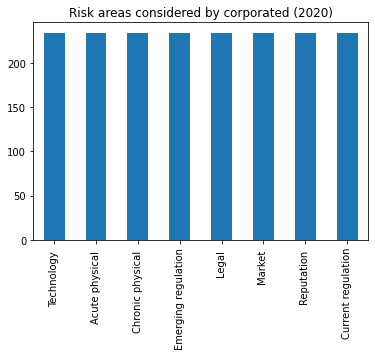

In [11]:
cc2_2a = get_climate('C2.2a', by='row_name')
cc2_2a.row_name.value_counts().plot(kind='bar', title='Risk areas considered by corporated (2020)');
# cc2_2a.pivot(index=['organization', 'row_name'], columns='column_name')

C2.3a Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business. (16255)


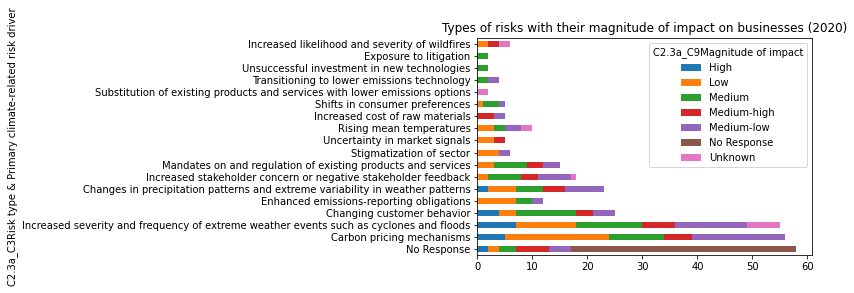

In [12]:
cc2_3a = get_climate('C2.3a')
piv2_3a = cc2_3a.pivot(index=['organization', 'row_number'], columns='column_name')['response_value']
piv2_3a[['C2.3a_C3Risk type & Primary climate-related risk driver', 'C2.3a_C9Magnitude of impact']] \
.groupby('C2.3a_C3Risk type & Primary climate-related risk driver')['C2.3a_C9Magnitude of impact'] \
.value_counts().sort_values(ascending=False)[:60].unstack() \
.plot(kind='barh', stacked=True, title='Types of risks with their magnitude of impact on businesses (2020)');

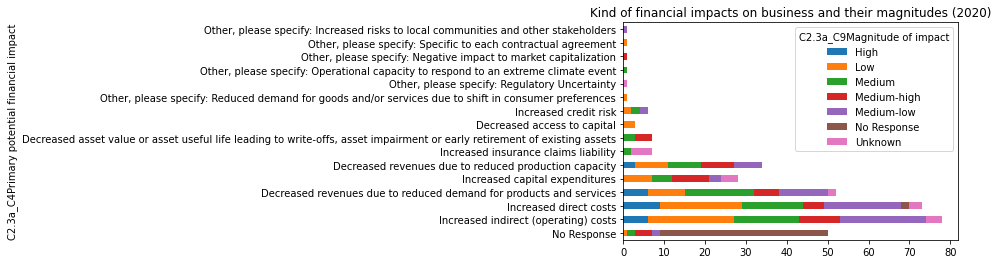

In [14]:
piv2_3a[['C2.3a_C4Primary potential financial impact', 'C2.3a_C9Magnitude of impact']]\
  .groupby('C2.3a_C4Primary potential financial impact')['C2.3a_C9Magnitude of impact']\
  .value_counts().sort_values(ascending=False)[:48].unstack()\
  .plot(kind='barh', stacked=True, title='Kind of financial impacts on business and their magnitudes (2020)')

C2.4a Provide details of opportunities identified with the potential to have a substantive financial or strategic impact on your business. (13471)


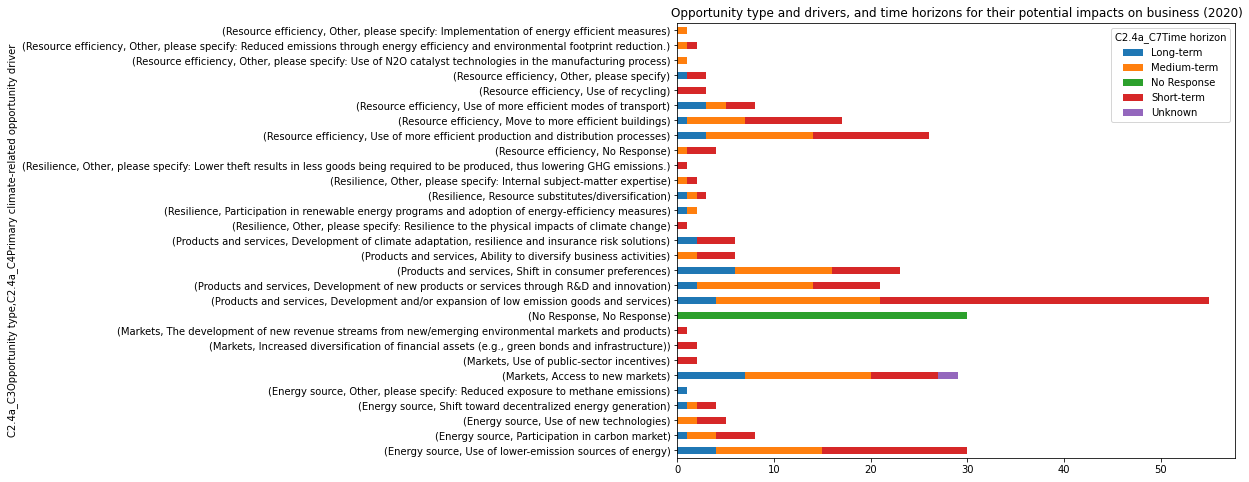

In [16]:
cc2_4a = get_climate('C2.4a')
ccpiv2_4a = cc2_4a.pivot(index=['organization', 'row_number'], columns='column_name')['response_value']
ccpiv2_4a[['C2.4a_C3Opportunity type','C2.4a_C4Primary climate-related opportunity driver', 'C2.4a_C7Time horizon']]\
  .groupby(['C2.4a_C3Opportunity type', 'C2.4a_C4Primary climate-related opportunity driver'])['C2.4a_C7Time horizon'].value_counts()\
  .sort_values(ascending=False)[:60].unstack()\
  .plot(kind='barh', figsize=(10, 8), stacked=True, title='Opportunity type and drivers, and time horizons for their potential impacts on business (2020)')

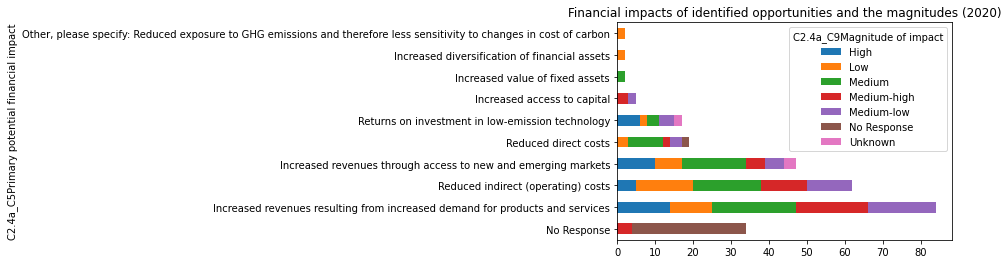

In [17]:
ccpiv2_4a[['C2.4a_C5Primary potential financial impact', 'C2.4a_C9Magnitude of impact']]\
  .groupby('C2.4a_C5Primary potential financial impact')['C2.4a_C9Magnitude of impact']\
  .value_counts().sort_values(ascending=False)[:33].unstack()\
  .plot(kind='barh', stacked=True, title='Financial impacts of identified opportunities and the magnitudes (2020)')

**Water Security**

Once more, we pick a set of most important questions which are relevant towards gaining insights into building KPIs for corporations with respect to their water security and risk.

In [18]:
qs_ws = ['W3.3a', 'W3.3b', 'W3.3c', 'W3.3d', 'W4.1b', 'W4.1c', 'W4.2', 'W4.2a', 'W4.3a', 'W5.1', 'W5.1a', 'W8.1', 'W8.1b']
# qs_ws = sorted(water[water['survey_year'] == 2019]['question_number'].unique())

for q in qs_ws:
  get_water(q, year=2020)

W3.3a Select the options that best describe your procedures for identifying and assessing water-related risks. (588)
W3.3b Which of the following contextual issues are considered in your organization's water-related risk assessments? (448)
W3.3c Which of the following stakeholders are considered in your organization's water-related risk assessments? (672)
W3.3d Describe your organization's process for identifying, assessing, and responding to water-related risks within your direct operations and other stages of your value chain. (28)
W4.1b What is the total number of facilities exposed to water risks with the potential to have a substantive financial or strategic impact on your business, and what proportion of your company-wide facilities does this represent? (84)
W4.1c By river basin, what is the number and proportion of facilities exposed to water risks that could have a substantive impact on your business, and what is the potential business impact associated with those facilities? (

W4.2 Provide details of identified risks in your direct operations with the potential to have a substantive financial or strategic impact on your business, and your response to those risks. (1458)


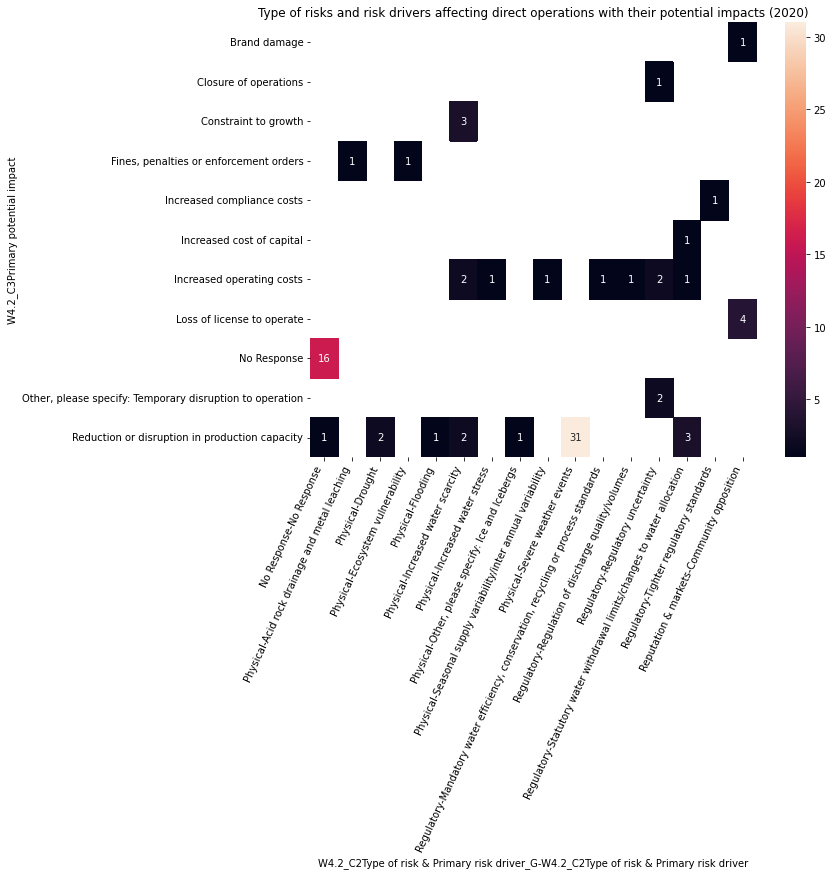

In [19]:
w4_2 = get_water('W4.2').pivot(index=['organization', 'row_number'], columns='column_name')['response_value']
plt.subplots(figsize=(10, 8))
sns.heatmap(
  w4_2.groupby(['W4.2_C2Type of risk & Primary risk driver_G', 'W4.2_C2Type of risk & Primary risk driver'])['W4.2_C3Primary potential impact']\
    .value_counts().sort_values(ascending=False)[:40].unstack().T, annot=True
)

plt.xticks(rotation=65, horizontalalignment='right',)
plt.title('Type of risks and risk drivers affecting direct operations with their potential impacts (2020)')
plt.show()

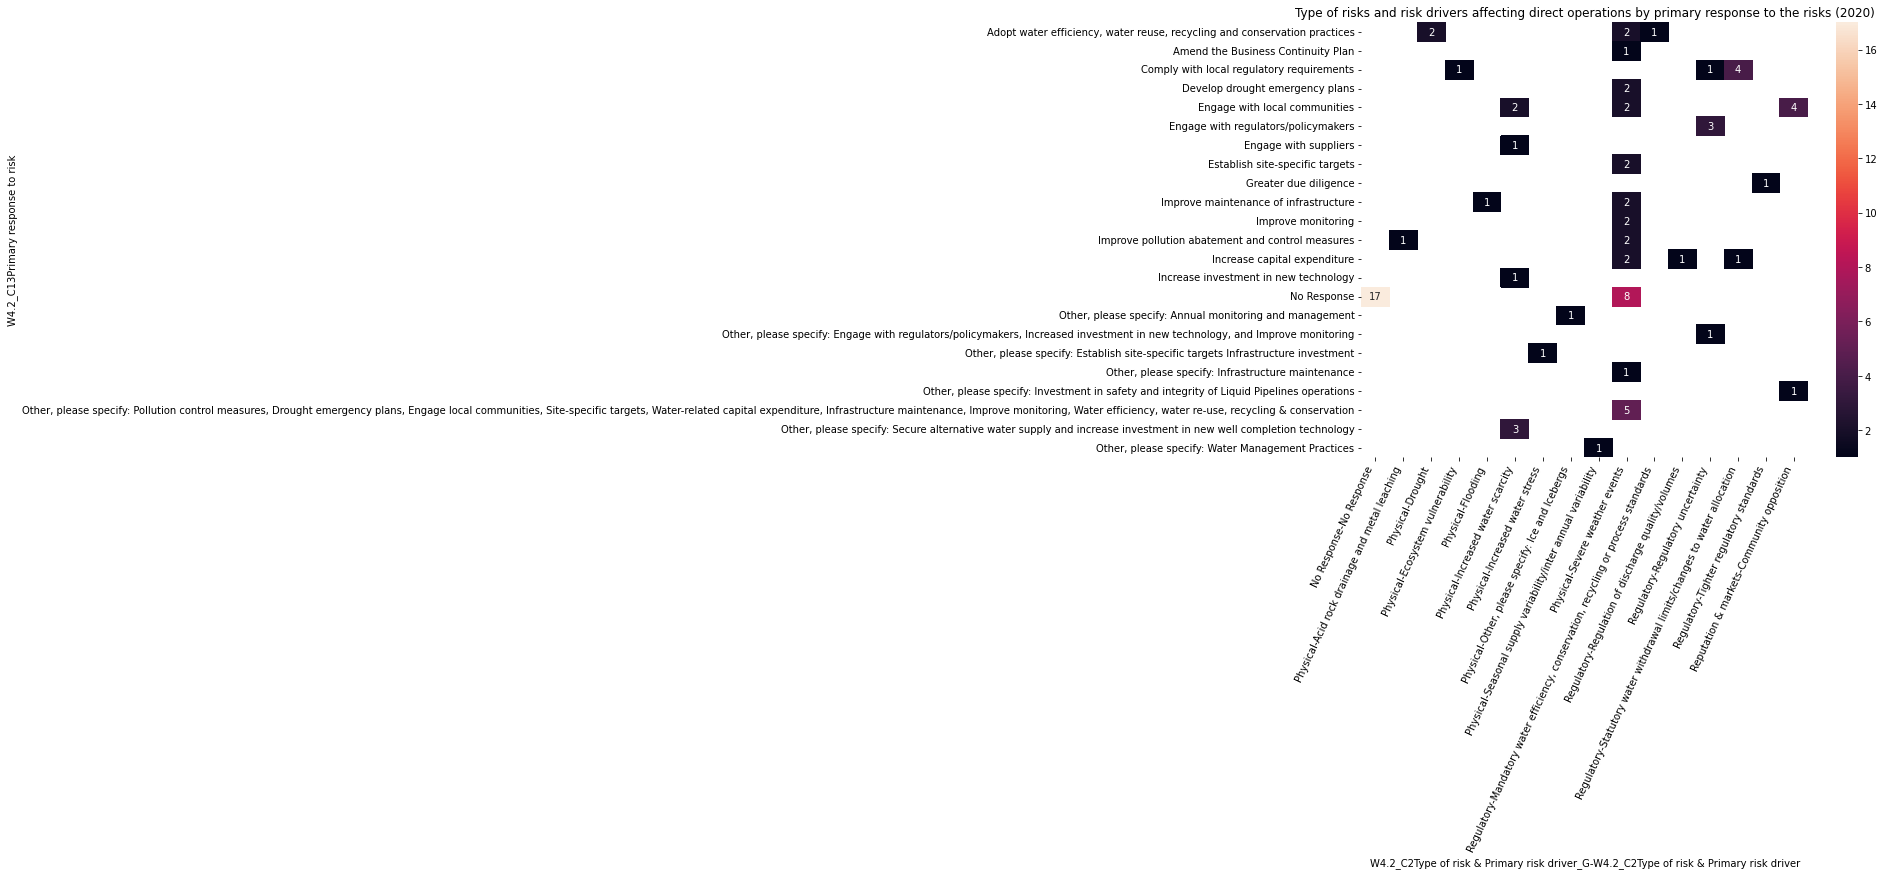

In [20]:
plt.subplots(figsize=(10, 8))
sns.heatmap(
  w4_2.groupby(['W4.2_C2Type of risk & Primary risk driver_G', 'W4.2_C2Type of risk & Primary risk driver'])['W4.2_C13Primary response to risk']\
    .value_counts().sort_values(ascending=False)[:40].unstack().T, annot=True
)

plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Type of risks and risk drivers affecting direct operations by primary response to the risks (2020)')
plt.show()

W4.2a Provide details of risks identified within your value chain (beyond direct operations) with the potential to have a substantive financial or strategic impact on your business, and your response to those risks. (580)


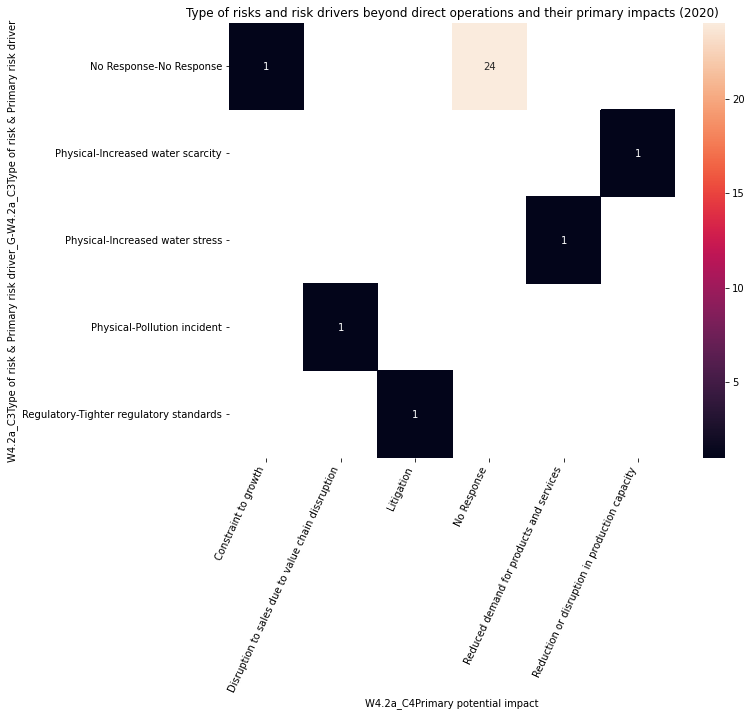

In [53]:
w4_2a = get_water('W4.2a').pivot(index=['organization', 'row_number'], columns='column_name')['response_value']
plt.subplots(figsize=(10, 8))
sns.heatmap(
  w4_2a.groupby(['W4.2a_C3Type of risk & Primary risk driver_G', 'W4.2a_C3Type of risk & Primary risk driver'])['W4.2a_C4Primary potential impact']\
    .value_counts().sort_values(ascending=False)[:].unstack(), annot=True
)

plt.xticks(rotation=65, horizontalalignment='right',)
plt.title('Type of risks and risk drivers beyond direct operations and their primary impacts (2020)')
plt.show()

In [54]:
get_water('W5.1a', cols=['country', 'organization']).pivot(index=['country', 'organization', 'row_number'], columns='column_name')['response_value']['W5.1a_C1% verified'].value_counts()

W5.1a For each facility referenced in W5.1, provide withdrawal data by water source. (560)


No Response     160
Not verified    101
76-100           14
26-50             5
Name: W5.1a_C1% verified, dtype: int64

W5.1c For each facility referenced in W5.1, provide the proportion of your total water use that is recycled or reused, and give the comparison with the previous reporting year. (350)


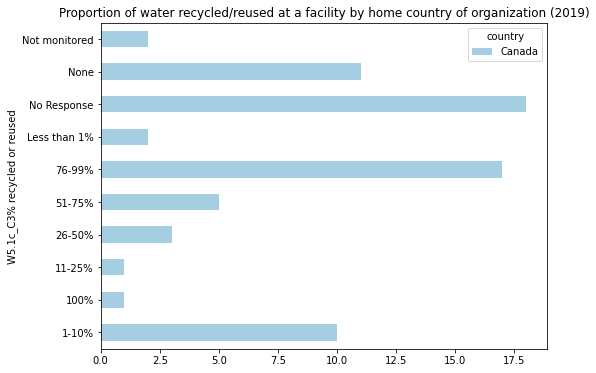

In [55]:
w5_1c = get_water('W5.1c', year=2019, cols=['country', 'organization']).pivot(index=['country', 'organization', 'row_number'], columns='column_name')['response_value']
w5_1c.groupby('country')['W5.1c_C3% recycled or reused'].value_counts().unstack(0)\
  .plot(kind='barh', stacked=True, figsize=(8, 6), title='Proportion of water recycled/reused at a facility by home country of organization (2019)')

W8.1 Describe your approach to setting and monitoring water-related targets and/or goals. (84)


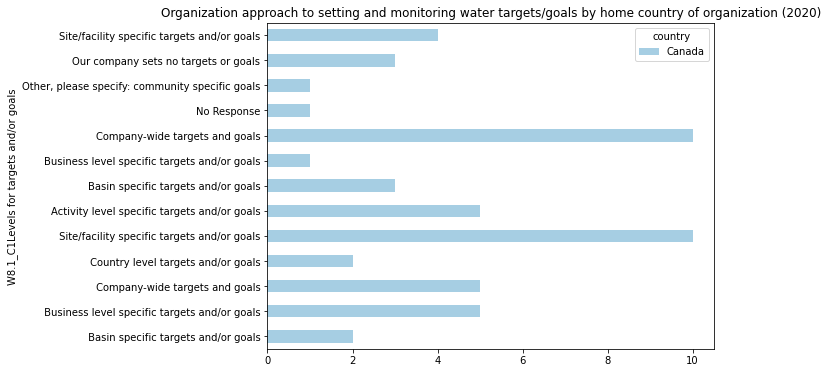

In [56]:
w8_1 = get_water('W8.1', cols=['organization', 'country']).pivot(index=['country', 'organization', 'row_number'], columns='column_name')['response_value']
w8_1['W8.1_C1Levels for targets and/or goals'].str.split(';').explode().to_frame().groupby('country')['W8.1_C1Levels for targets and/or goals'].value_counts()\
  .sort_values(ascending=False)[:26].unstack(0)\
  .plot(kind='barh', figsize=(8, 6), stacked=True, title='Organization approach to setting and monitoring water targets/goals by home country of organization (2020)')

W8.1a Provide details of your water targets that are monitored at the corporate level, and the progress made. (473)


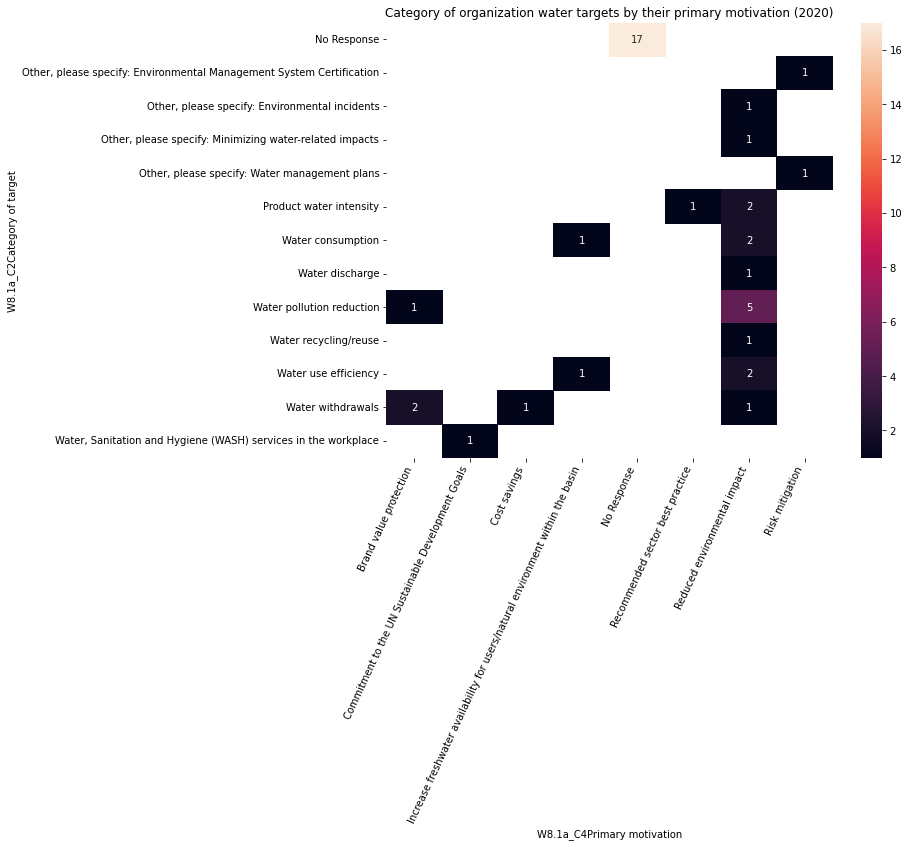

In [57]:
w8_1a = get_water('W8.1a').pivot(index=['organization', 'row_number'], columns='column_name')['response_value']
plt.subplots(figsize=(10, 8))
sns.heatmap(w8_1a.groupby('W8.1a_C2Category of target')['W8.1a_C4Primary motivation'].value_counts().sort_values(ascending=False)[:50].unstack(), annot=True)
plt.xticks(rotation=65, horizontalalignment='right',)
plt.title('Category of organization water targets by their primary motivation (2020)')
plt.show()

W8.1b Provide details of your water goal(s) that are monitored at the corporate level and the progress made. (288)


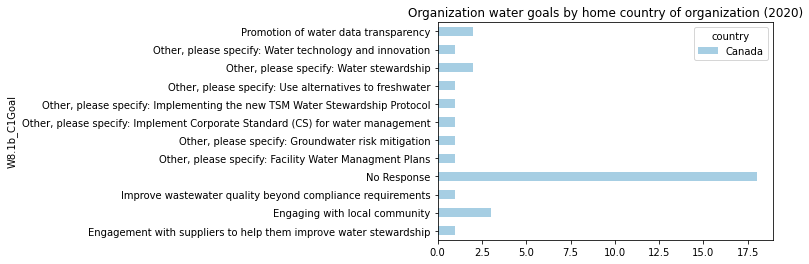

In [58]:
w8_1b = get_water('W8.1b', cols=['country', 'organization']).pivot(index=['country', 'organization', 'row_number'], columns='column_name')['response_value']
w8_1b.groupby(['country'])['W8.1b_C1Goal'].value_counts().sort_values(ascending=False)[:90].unstack(0)[:12]\
  .plot(kind='barh', stacked=True, title='Organization water goals by home country of organization (2020)')

**City Responses**

In [59]:
x = cr.groupby('Year Reported to CDP').size()
x.sort_values(ascending = False)

Year Reported to CDP
2020    274328
2019    136846
2018     70226
dtype: int64

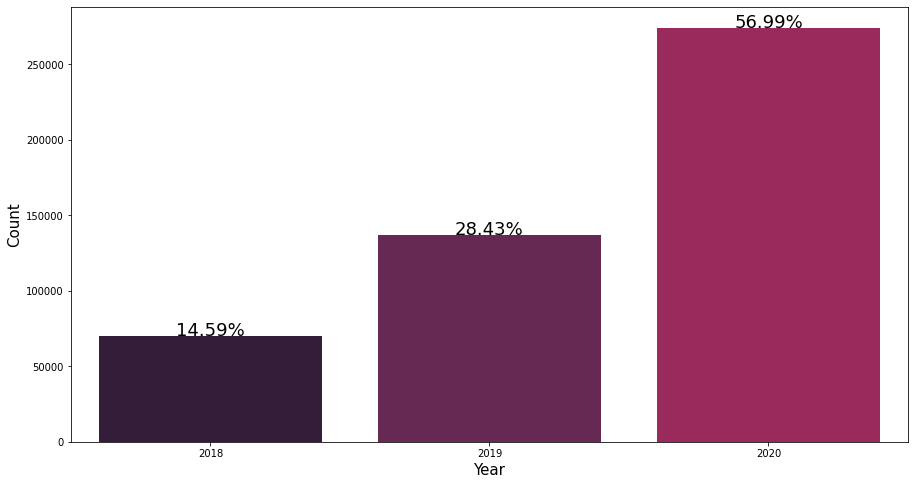

In [60]:
plt.figure(figsize=(15, 8))
freq = len(cr)
sns.set_palette("rocket")
g = sns.countplot(cr['Year Reported to CDP'])
g.set_xlabel('Year', fontsize = 15)
g.set_ylabel("Count", fontsize = 15)

for p in g.patches:
  height = p.get_height()
  g.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2f}%'.format(height / freq * 100), ha = "center", fontsize = 18)

In [61]:
group = cr.groupby('Country').size()
group.sort_values(ascending = False)

Country
United States of America    400078
Canada                       81322
dtype: int64

In [62]:
top_10 = cr['Country'].value_counts()
top_10 = top_10[:10,]
top_10

United States of America    400078
Canada                       81322
Name: Country, dtype: int64

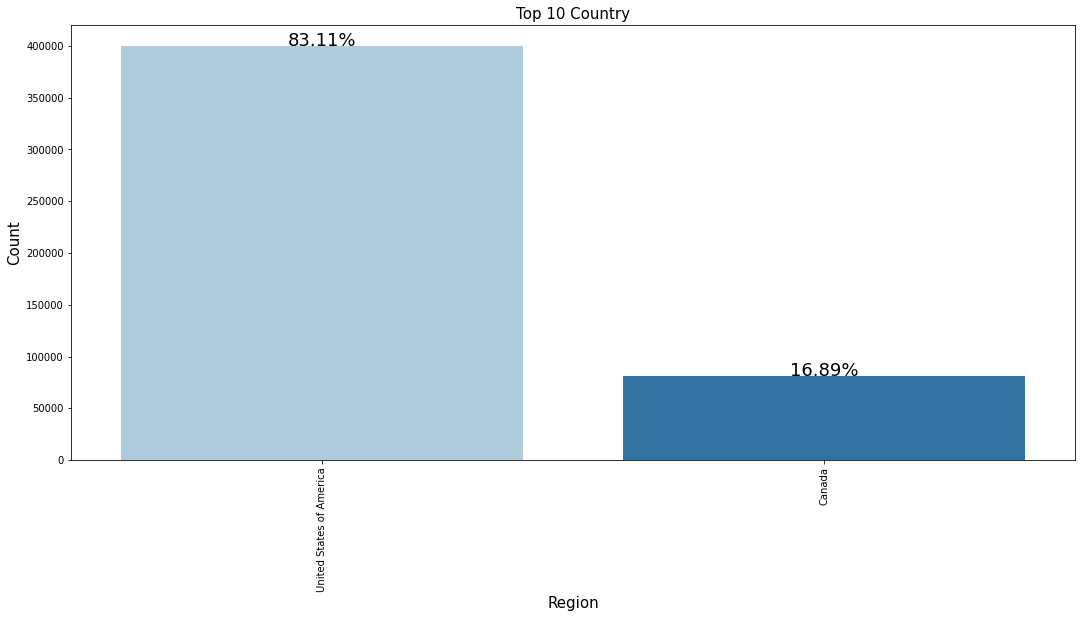

In [63]:
plt.figure(figsize=(18, 8))
freq = len(cr)
sns.set_palette("Paired")
g = sns.barplot(top_10.index, top_10.values)
g.set_title('Top 10 Country', fontsize = 15)
g.set_xlabel('Region', fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
plt.xticks(rotation = 90)

for p in g.patches:
  height = p.get_height()
  g.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2f}%'.format(height / freq * 100), ha = "center", fontsize = 18)

In [64]:
x = cr.groupby('City').size()
x.sort_values(ascending = False)

City
City of Toronto          7024
City of Windsor          6109
District of Columbia     5457
City of San Francisco    5256
City of Calgary          4754
                         ... 
City of Ramsey, MN        204
Town of Secaucus, NJ      190
City of Clinton, IA       188
Los Altos Hills           185
City of Elgin, IL         183
Length: 226, dtype: int64

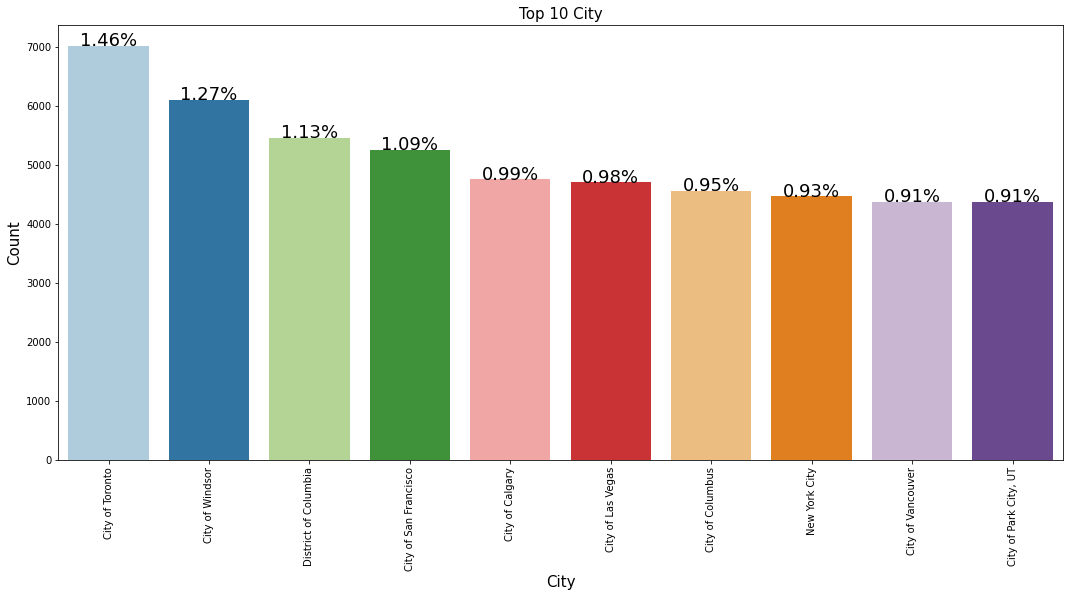

In [65]:
top = cr['City'].value_counts()
top_10 = top[:10,]
plt.figure(figsize=(18, 8))
freq = len(cr)
sns.set_palette("Paired")
g = sns.barplot(top_10.index, top_10.values)
g.set_title('Top 10 City', fontsize = 15)
g.set_xlabel('City', fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
plt.xticks(rotation=90)

for p in g.patches:
  height = p.get_height()
  g.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2f}%'.format(height / freq * 100), ha = "center", fontsize = 18)

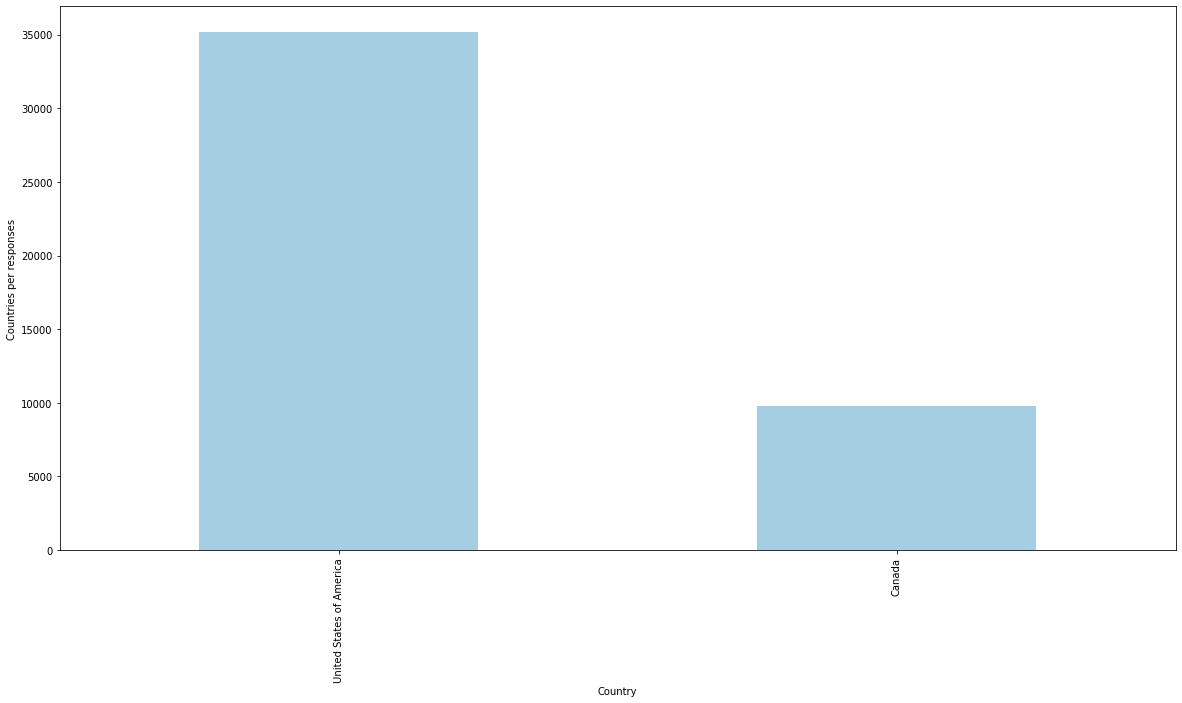

In [66]:
plt.figure(figsize=(20,10))
cr.groupby('Country').nunique()['Response Answer'].sort_values(ascending=False)[:50].plot(kind='bar')
plt.ylabel('Countries per responses')
plt.show()

In [67]:
# Number of coments per city
city_group = cr.groupby('City')['Response Answer'].count().reset_index().sort_values('Response Answer', ascending=False).head(15)
city_group

,City,Response Answer
174,City of Toronto,7024
181,City of Windsor,6109
188,District of Columbia,5457
150,City of San Francisco,5256
31,City of Calgary,4754
98,City of Las Vegas,4703
43,City of Columbus,4557
196,New York City,4467
176,City of Vancouver,4378
127,"City of Park City, UT",4375


Toronto has the most city responses to whether they see climate change as an opportunity or concern, followed closed by Windsor. Rest of the cities are significantly lagging behind.

In [68]:
def get_top_n_words(corpus, n=None):
  vec = CountVectorizer(stop_words = 'english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_top_n_words(cr['Response Answer'], 20)
for word, freq in common_words:
  print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])
fig = px.bar(df1, x='word', y='count')
fig.update_layout(title_text='Response Answer word count top 20', template="plotly_white")
fig.show()

response 114859
applicable 108898
question 108843
city 35704
energy 21867
water 21229
climate 14808
plan 13392
emissions 12140
community 10605
public 9919
yes 9618
increased 8688
infrastructure 8213
change 6913
development 6900
high 6893
local 6848
services 6347
implementation 6220


The most commonly used words in the city answers are applicable, water, energy and climate, followed up by emission and change

In [69]:
def get_top_n_bigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_top_n_bigram(cr['Response Answer'], 20)
for word, freq in common_words:
  print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['word' , 'count'])

fig = px.bar(df2, x='word', y='count')
fig.update_layout(title_text='Answers bigram count top 20', template="plotly_white")
fig.show()

question applicable 108753
climate change 5789
public health 3442
https www 3378
action plan 3101
renewable energy 2969
energy efficiency 2931
sea level 2857
water supply 2806
level rise 2700
climate action 2614
ghg emissions 2536
greenhouse gas 2522
extreme hot 2258
increased demand 2011
gas emissions 1879
improved resource 1763
vulnerable populations 1720
low income 1716
finance secured 1695


From the top bigrams in the comments, we can see that the cities are generally more concerned about climate change. Most cities view that climate hazards represent either a significant or moderate challenge.

In [136]:
cities = cr[(cr["Question Number"] == '2.2')]
cities = cities.loc[:, ['Year Reported to CDP', 'City', 'Country', 'CDP Region', 'Section', 'Question Name', 'Response Answer']]

df = cities
df['Country'].unique()

array(['United States of America', 'Canada'], dtype=object)

In [138]:
def comment_len(x):
  if type(x) is str:
    return len(x.split())
  else:
    return 0

df = df[df['Year Reported to CDP'] == 2020]
df['answer_len'] = df['Response Answer'].apply(comment_len)
nums_comment = df.query('answer_len > 0')['answer_len']

fig = ff.create_distplot(hist_data = [nums_comment], group_labels = ['Response Answer'])
fig.update_layout(title_text='Distribution of word count in comment', template="plotly_white")
fig.show()

**Sentiment Polarity**

We will use TextBlob to calculate sentiment polarity which lies in the range of [-1,1] where 1 means positive sentiment and -1 means a negative sentiment.

In [139]:
df['sentiment'] = df['Response Answer'].apply(lambda x: TextBlob(x).sentiment[0])

df.loc[df['sentiment'] > 0, 'Opportunity_Concern'] = 'Opportunity'
df.loc[df['sentiment'] == 0, 'Opportunity_Concern'] = 'Opportunity'
df.loc[df['sentiment'] < 0, 'Opportunity_Concern'] = 'Concern'

df.head()

,Year Reported to CDP,City,Country,CDP Region,Section,Question Name,Response Answer,answer_len,sentiment,Opportunity_Concern
222,2020,"Town of Breckenridge, CO",United States of America,North America,Climate Hazards,Please identify and describe the factors that ...,Cost of living is high and many properties are...,26,0.133750,Opportunity
330,2020,"District of Saanich, BC",Canada,North America,Climate Hazards,Please identify and describe the factors that ...,Somewhat challenges,2,0.000000,Opportunity
535,2020,"City of Kingston, ON",Canada,North America,Climate Hazards,Please identify and describe the factors that ...,No Response,2,0.000000,Opportunity
1326,2020,City of Los Angeles,United States of America,North America,Climate Hazards,Please identify and describe the factors that ...,"Inequality in socioeconomic status, quality of...",33,0.053333,Opportunity
1560,2020,"City of Miami Beach, FL",United States of America,North America,Climate Hazards,Please identify and describe the factors that ...,Infrastructure conditions / maintenance,4,0.000000,Opportunity


In [131]:
temp = df.groupby('Opportunity_Concern').count()['Response Answer'].reset_index().sort_values(by='Response Answer',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Opportunity_Concern,Response Answer
1,Opportunity,3204
0,Concern,148


In [132]:
sentiment = df['Opportunity_Concern'].value_counts()
fig = {
  "data": [
    {
      "values": sentiment.values,
      "labels": sentiment.index,
      "domain": {"x": [0, .6]},
      "name": "Region",
      "hoverinfo":"label+percent+name",
      "hole": .5,
      "type": "pie"
    },],
  "layout": {
    "annotations": [{
      "font": { "size": 20 },
      "showarrow": False,
      "text": "CDP Opportunity Concern",
      "x": 0.50,
      "y": 1
    }]
  }
}
iplot(fig)

In [77]:
df.loc[df['Opportunity_Concern'] == 'Opportunity'].Country.value_counts()

United States of America    2647
Canada                       557
Name: Country, dtype: int64

In [78]:
df.loc[df['Opportunity_Concern'] == 'Concern'].Country.value_counts()

United States of America    117
Canada                       31
Name: Country, dtype: int64

Interesting observation that Canadian cities are much more skeptical on climate issues comapred to American cities.

In [79]:
fig = px.histogram(df, x="sentiment")
fig.update_layout(title_text='Distribution of sentiment polarity in Cities answers', template="plotly_white")
fig.show()

From the sentiment polarity distribution above, we can see that many cities did not answer or provided very short answers regarding climate hazards (there is a significant peak close to 0). This could be because climate change is a relatively new area and cities are finding it difficult to calculate it and thus unable to discuss clearly how it could be an opportunity or concern to them

In [80]:
fig = px.scatter(df, x='sentiment', y='answer_len', color='Opportunity_Concern', template="plotly_white")
fig.update_layout(title_text='Sentiment polarity')
fig.show()

The scatter plot shows a clear distinction between opportunity and concern over future climate scenarios.

In [81]:
fig = px.histogram(df, x="answer_len", y="Country", color="Opportunity_Concern", marginal="box", hover_data=df.columns, nbins=100)
fig.update_layout(title_text='Distribution of sentiment per country', template="plotly_white")
fig.show()

In [83]:
Columbus_polarity = df.query("sentiment != 1000 and City == 'City of Columbus'")['sentiment']
Vancouver_polarity = df.query("sentiment != 1000 and City == 'City of Vancouver'")['sentiment']

fig = ff.create_distplot(hist_data=[Columbus_polarity, Vancouver_polarity], group_labels=['City of Columbus', 'City of Vancouver'], colors=px.colors.qualitative.Plotly[5:], show_hist=False)
fig.update_layout(title_text="Comment sentiment polarity vs cities", xaxis_title='sentiment polarity', template="plotly_white")
fig.show()

In [84]:
df2 = df.loc[(df['City'] == 'City of City of Vancouver') | (df['City'] == 'City of Charlotte') | (df['City'] == 'City of Eugene')]
polarity_group = df2.groupby('City')['sentiment'].mean().reset_index()

colors = ['lightslategray',] * 5
colors[2] = 'crimson'
fig = go.Figure(data=[go.Bar(x=polarity_group['City'].unique(), y=polarity_group['sentiment'], marker_color=colors)])
fig.update_layout(title_text='Lowest average sentment polarity')

Answers from the city of Eugene had the lowest average sentiment polarity score. In part, the city of Eugene did not provide as many answers as the city of Charlotte or Colombus.

# **Naturel Language Processing**

In [85]:
from tabulate import tabulate
import ipywidgets as widgets

import gensim
import heapq
import spacy
nlp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud
from IPython.display import display
import base64

from collections import Counter

**1. Sentiment Analysis**

In this section, we will explore text mining techniques for sentiment analysis to detect whether a city sees opportunity (Cities Question 6.0) or concern (City Question 2.2) over future climate scenarios. First, we clean the text data, removing stop words and stemming. To infer the tweets’ sentiment we use two classifiers: logistic regression and multinomial naive Bayes.

In [147]:
df.rename(columns={'Response Answer':'Response_Answer'}, inplace=True)

df_full = df[['Year Reported to CDP', 'City', 'Country', 'Question Name', 'Response Answer', 'answer_len', 'sentiment', 'Opportunity_Concern']]
df_full.head()

,Year Reported to CDP,City,Country,Question Name,Response Answer,answer_len,sentiment,Opportunity_Concern
222,2020,"Town of Breckenridge, CO",United States of America,Please identify and describe the factors that ...,Cost of living is high and many properties are...,26,0.133750,Opportunity
330,2020,"District of Saanich, BC",Canada,Please identify and describe the factors that ...,Somewhat challenges,2,0.000000,Opportunity
535,2020,"City of Kingston, ON",Canada,Please identify and describe the factors that ...,No Response,2,0.000000,Opportunity
1326,2020,City of Los Angeles,United States of America,Please identify and describe the factors that ...,"Inequality in socioeconomic status, quality of...",33,0.053333,Opportunity
1560,2020,"City of Miami Beach, FL",United States of America,Please identify and describe the factors that ...,Infrastructure conditions / maintenance,4,0.000000,Opportunity


In [140]:
df = df.loc[:, ['Response Answer', 'Opportunity_Concern']]
df.head()

,Response Answer,Opportunity_Concern
222,Cost of living is high and many properties are...,Opportunity
330,Somewhat challenges,Opportunity
535,No Response,Opportunity
1326,"Inequality in socioeconomic status, quality of...",Opportunity
1560,Infrastructure conditions / maintenance,Opportunity


**1.1 Text cleaning**

we’ll perform the following actions:

* set all words to lowercase
* remove all punctuations, including the question and exclamation marks
* remove digits
* remove stopwords
* apply the PorterStemmer to keep the stem of the words

In [159]:
class TextCounts(BaseEstimator, TransformerMixin):
    def count_regex(self, pattern, Response_Answer):
        return len(re.findall(pattern, Response_Answer))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

class CleanText(BaseEstimator, TransformerMixin):
  def remove_mentions(self, input_text):
    return re.sub(r'@\w+', '', input_text)
  
  def remove_urls(self, input_text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
  
  def emoji_oneword(self, input_text):
    # By compressing the underscore, the emoji is kept as one word
    return input_text.replace('_','')
  
  def remove_punctuation(self, input_text):
    # Make translation table
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
    return input_text.translate(trantab)
  def remove_digits(self, input_text):
    return re.sub('\d+', '', input_text)
  
  def to_lower(self, input_text):
    return input_text.lower()
  
  def remove_stopwords(self, input_text):
    stopwords_list = stopwords
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
  
  def stemming(self, input_text):
    porter = PorterStemmer()
    words = input_text.split() 
    stemmed_words = [porter.stem(word) for word in words]
    return " ".join(stemmed_words)
  
  def fit(self, X, y=None, **fit_params):
    return self
  
  def transform(self, X, **transform_params):
    clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
    return clean_X

tc = TextCounts()
df_eda = tc.fit_transform(df.Response_Answer)
df_eda['Opportunity_Concern'] = df.Opportunity_Concern

# A sample on how the cleaned text variable will look like:
ct = CleanText()
sr_clean = ct.fit_transform(df.Response_Answer)
sr_clean.sample(5)

600588    impact climat chang often less like engag time...
385398                                         govern capac
815025                                           no respons
73232     flood plain area typic low lie area proxim riv...
746744                                              support
Name: Response_Answer, dtype: object

A down-side of the text cleaning is that some rows do not have any words left in their text. We fix this by imputing the missing value with some placeholder text such as: 'no_text'

In [90]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


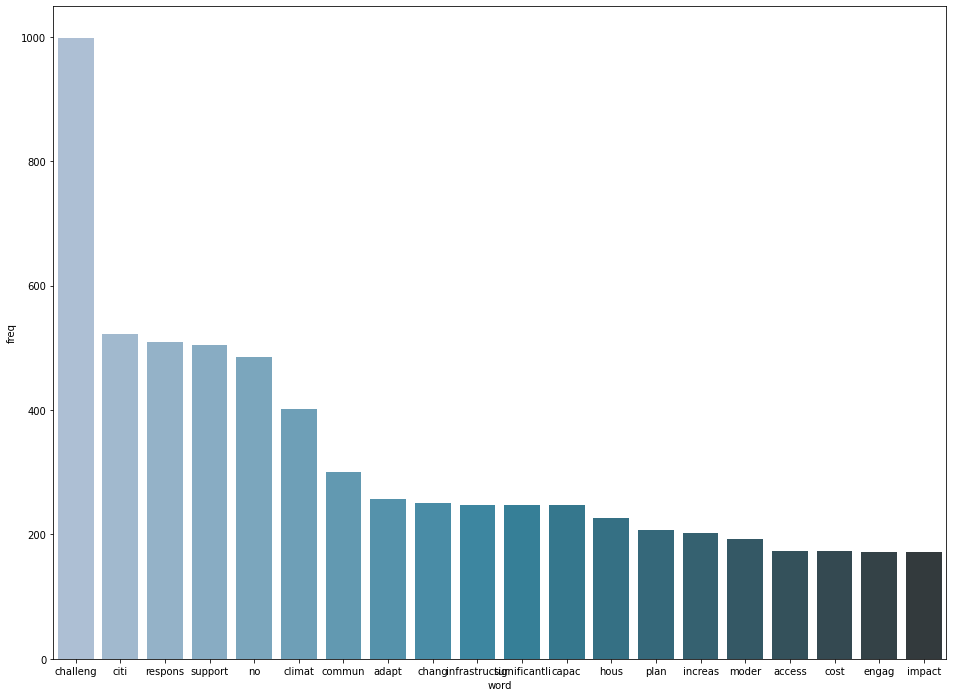

In [91]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(16, 12))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show()

**1.2 Test data**

In [92]:
# Creating test data
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'Opportunity_Concern',
 'clean_text']

In [93]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('Opportunity_Concern', axis=1), df_model.Opportunity_Concern, test_size=0.1, random_state=37)

**1.3 Evaluation metrics**

In [94]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
  'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
  'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
  'features__pipe__vect__min_df': (1,2)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
  'clf__alpha': (0.25, 0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
  'clf__C': (0.25, 0.5, 1.0),
  'clf__penalty': ('l1', 'l2')
}

def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
  textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags','count_mentions','count_urls','count_words']
  
  if is_w2v:
    w2vcols = []
    for i in range(SIZE):
      w2vcols.append(i)
    features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols)), ('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
  else:
      features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols)), ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))], n_jobs=-1)
  
  pipeline = Pipeline([('features', features), ('clf', clf)])
  
  # Join the parameters dictionaries together
  parameters = dict()
  if parameters_text:
    parameters.update(parameters_text)
  parameters.update(parameters_clf)
  # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
  grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
  
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  pprint(parameters)
  t0 = time()
  grid_search.fit(X_train, y_train)
  print("done in %0.3fs" % (time() - t0))
  print("\nBest CV score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
  print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
  print("\nClassification Report Test Data")
  print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                      
  return grid_search

**1.4 Classifying the model - CountVectorizer**

In [95]:
# Classifiers
mnb = MultinomialNB()
logreg = LogisticRegression()

Converting text into numbers using CountVectorizer

In [96]:
countvect = CountVectorizer()
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 22.075s

Best CV score: 0.960
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.946

Classification Report Test Data
              precision    recall  f1-score   support

     Concern       1.00      0.10      0.18        20
 Opportunity       0.95      1.00      0.97       316

    accuracy                           0.95       336
   macro avg       0.97      0.55      0.58       336
weighted avg       0.95      0.95      0.93       336

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 '

The Logistic Regression classifier and the Multinomial Naive Bayes classifier achieve good results when using CountVectorizer

**1.5 Deploying the model**

Let's detect from responses of cities whether whether a city sees future climate scenarios an opportunity or concern

In [97]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags','count_mentions','count_urls','count_words']
features = FeatureUnion([
  ('textcounts', ColumnExtractor(cols=textcountscols)),
  ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))
], n_jobs=-1)
pipeline = Pipeline([('features', features), ('clf', LogisticRegression(C=1.0, penalty='l2'))])

best_model = pipeline.fit(df_model.drop('Opportunity_Concern', axis=1), df_model.Opportunity_Concern)

# Applying on new positive tweets
new_positive_tweets = pd.Series([
  'The City of Pittsburgh has signed a memorandum of understanding with the Department of Energy to improve \
  distributed district energy systems that will improve efficiency and resilience with microgrids and CHP systems and renewable energy'
])
df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

# Applying on new negative tweets
new_negative_tweets = pd.Series(["Other, please specify"])
df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

print(best_model.predict(df_model_pos).tolist())
print(best_model.predict(df_model_neg).tolist())

['Opportunity']
['Concern']


# **2. Text Summarizing**

In this part, we attempt to summarise city 'readiness' for climate change and the hazards they anticipate (Cities Question 2.1)

In [98]:
review  = cr[(cr["Question Number"] == '2.1')]
review = review.loc[(review['Country'] == 'United States of America') | (review['Country'] == 'Canada')]
review  = review.loc[:, ['City', 'Response Answer']]
review['Response Answer'] = review['Response Answer'].fillna('No Response')
review['comment'] = review['Response Answer']
review = review .drop(['Response Answer'], axis =1)

pre = review.reset_index(drop=True)
pre.head()

,City,comment
0,City of St Louis,No
1,City of Indianapolis,Yes
2,"City of San Leandro, CA",Yes
3,Ville de Laval,No
4,City of Seattle,Yes


**2.1 Text cleaning**

In [104]:
# Clean text before feeding it to spacy
# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'

def normalize_text(text):
  tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
  tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
  tm3 = re.sub('<[^>]+>', '', tm1, flags=re.DOTALL)
  return tm3.replace("\n", "")

def cleanup_text(docs, logging=False):
  texts = []
  doc = nlp(docs, disable=['parser', 'ner'])
  tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
  tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
  tokens = ' '.join(tokens)
  texts.append(tokens)
  return pd.Series(texts)

pre['Body_Cleaned_1'] = pre['comment'].apply(normalize_text)
pre['Body_Cleaned'] = pre['Body_Cleaned_1'].apply(lambda x: cleanup_text(x, False))
print('City answer with punctuation and stopwords\n')
print(pre['Body_Cleaned_1'][40399])
print('\nCity answer after removing punctuation and stopwords\n')
print(pre['Body_Cleaned'][40399])

City answer with punctuation and stopwords

High

City answer after removing punctuation and stopwords

high


**2.2 Text summarizing**

We first need to convert the whole all paragraphs into sentences. The most common way of converting paragraphs to sentences is to split the paragraph whenever a period is encountered. Second, We remove all the special characters, stop words and numbers from all the sentences. Third, We tokenize all the sentences to get all the words that exist in the sentences. Fourth, We find the weighted frequency of occurrences of all the words by dividing its frequency by the frequency of the most occurring word. Finally, plug the weighted frequency in place of the corresponding words in original sentences and finding their sum, then sort the sentences in inverse order of their sum. The sentences with highest frequencies summarize the text.

In [106]:
def generate_summary(text_without_removing_dot, cleaned_text):
  sample_text = text_without_removing_dot
  doc = nlp(sample_text)
  sentence_list=[]
  for idx, sentence in enumerate(doc.sents): # we are using spacy for sentence tokenization
    sentence_list.append(re.sub(r'[^\w\s]','',str(sentence)))

  stopwords = nltk.corpus.stopwords.words('english')

  word_frequencies = {}  
  for word in nltk.word_tokenize(cleaned_text):  
    if word not in stopwords:
      if word not in word_frequencies.keys():
        word_frequencies[word] = 1
      else:
        word_frequencies[word] += 1

  maximum_frequncy = max(word_frequencies.values())
  for word in word_frequencies.keys():  
    word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

  sentence_scores = {}  
  for sent in sentence_list:  
    for word in nltk.word_tokenize(sent.lower()):
      if word in word_frequencies.keys():
        if len(sent.split(' ')) < 30:
          if sent not in sentence_scores.keys():
            sentence_scores[sent] = word_frequencies[word]
          else:
            sentence_scores[sent] += word_frequencies[word]

  summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)
  summary = ' '.join(summary_sentences)
  print("Original Text::::::::::::\n")
  print(text_without_removing_dot)
  print('\n\nSummarized text::::::::\n')
  print(summary)

generate_summary(pre['Body_Cleaned_1'][40399], pre['Body_Cleaned'][40399])

Original Text::::::::::::

High


Summarized text::::::::

High


# Actionable Recommendations

Cities will be able to used the analysis to understand the 

# Alternative Analysis
## External data for baseline of water stress 

**Physical risk quantity:**

| Short    | Full |
|-------------|-----|
|**bws**| Baseline water stress|  
|**bwd**| Baseline water depletion|  
|**iav**| Interannual variability|  
|**sev**| Seasonal variability|  
|**gtd**| Groundwater table decline|  
|**rfr**| Riverine flood risk|  
|**cfr**| Coastal flood risk|  
|**drr**| Drought risk|

**Types:**

| Type   | Data Type | Description |
|------------------|-------------|-----|
|**\_raw**| (double) | raw value. Units depend on the indicator. See the technical note.|  
|**\_score**| (double) | each indicator is mapped to a [0-5] scale.|  
|**\_label**| (string) | A label explaining the category of the indicator including threshold. e.g. "Extremely High (more than 1 in 100)".|  
|**\_cat**| (integer) | integer for each category [-1,4], can be used for visuals.|  

In [118]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [120]:
water = pd.read_csv('/content/drive/MyDrive/Water/GlobalMaps Baseline Annual Water Risk.csv')

with open('/content/drive/MyDrive/Water/us_state_abbrev.json') as f:
  us_state_abbrev = json.load(f)

water_df = water[water.gid_0.isin(na_countries.Code3)]
water_stress_df_mod = water_df[['name_0', 'name_1', 'bws_score']][(
  ((water_df.name_0 != '-9999') & (water_df.name_1 != '-9999') & (water_df.bws_score != -9999))
)].drop_duplicates()
water_stress_df_mod.columns = ['country', 'area', 'water_stress_level']
water_stress_df_mod['water_stress_level_norm'] = water_stress_df_mod['water_stress_level'] / 5

water_stress_df_mod_na = water_stress_df_mod.copy()
water_stress_df_mod_na['area'] = water_stress_df_mod_na['area'].replace(us_state_abbrev).copy()
water_stress_df_mod_na = water_stress_df_mod_na.groupby(['area', ]).water_stress_level_norm.mean().to_frame().reset_index(drop = False)
water_stress_level_by_country = water_stress_df_mod.groupby(['country']).water_stress_level_norm.mean().to_frame().reset_index(drop = False)

## EDA

Stress Level by Countries

In [121]:
fig = make_subplots(rows = 1, cols = 1, specs = [[{'type': 'choropleth'} for c in np.arange(1)] for r in np.arange(1)])
fig.update_layout(dict(title_text = "Water Stress Level", geo_scope = 'north america', ))
fig.add_trace(go.Choropleth(
  locations = water_stress_level_by_country.country, z = water_stress_level_by_country.water_stress_level_norm, zmax = 1,
  locationmode = 'country names', colorscale = px.colors.sequential.YlOrRd
), row = 1, col = 1)

Stress Level By States in USA

In [122]:
fig.add_trace(go.Choropleth(
  locations = water_stress_df_mod_na.area, zmax = 1, z = water_stress_df_mod_na.water_stress_level_norm,
  locationmode = 'USA-states', marker_line_color = 'white', geo = 'geo', colorscale = px.colors.sequential.YlOrRd, 
))    
fig.update_layout(dict(title_text = "Water Stress Level by State in the United States of America", geo_scope = 'usa',))   

In [322]:
df_model = cr[['Account Number', 'Year Reported to CDP', 'Question Number', 'Question Name', 'Column Name', 'Response Answer', 'CDP Region']]
df_model = df_model.loc[df_model['CDP Region'].isin(['North America'])]
df_model['Question'] = df_model['Question Name'] + df_model['Column Name']
df_model = df_model\
  .loc[df_model['Question Number'].isin([
    '2.0', '2.0a', '2.0b', '2.0c', '2.0d', '2.1', '2.1a', '2.1b', '2.1c', '2.2', '2.3', '2.3a', '3.0', '3.1', '3.2', '3.2a', '3.2b',
    '14.0', '14.1', '14.2', '14.2a', '14.2b', '14.3', '14.4', '14.4a', '14.4b'
  ])][['Account Number', 'Year Reported to CDP', 'Question', 'Response Answer']]

df_model = df_model.pivot_table(
  index = ['Account Number', 'Year Reported to CDP'],
  columns = ['Question'],
  values = 'Response Answer',
  aggfunc = lambda x: ' '.join(x), fill_value = ''
).reset_index()
df_model.rename(columns = {'Response Answer':'Response_Answer'}, inplace = True)

for c in df_model.columns:
  if c not in ['Question', 'Account Number', 'Year Reported to CDP', 'index']:
    df_model[c] = ct.fit_transform(df_model[c])

df_model['text'] = df_model[[c for c in df_model.columns if c not in ['Question', 'Account Number', 'Year Reported to CDP', 'index']]].agg(' '.join, axis=1)
df_model = pd.concat([df_model, tc.fit_transform(df_model.text)], axis = 1)

Unable to Train model in time so a simple outline on methodology provided instead.

Data have been preprocess and feature engeenring with sentiment, response length etc will be provided to a gbm and nn model to predict the actual risk level assumed by the city. This will then be contrasted to the baseline provided by Aqueduct data and the difference calculated on how much the city is overreporting or under reporting the problem.